In [1]:
import os
import sys
import opendatasets as od
from joblib import parallel_backend
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as sopt
import scipy.stats as sstats
import seaborn as sns
import sklearn.ensemble
import sklearn.tree
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from matplotlib import animation, pyplot, rc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.utils import resample
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from datetime import datetime, time
import json 

PLOT_MODULE = "/home/meks/Desktop/Flight-Delay-Prediction-Project/ml/"
sys.path.append(PLOT_MODULE)

from EDA_plottings import run_plots

# garbage collector so we can save memory
import gc

# Problem Statement and Objectives


# Data Colection


## Importing preprocessed data 


We will be importing data that was merged data of flight dataset from kaggle
and weather from visual crossing (https://www.visualcrossing.com) page. Thanks for cooperation with them,
we were allowed to make large queries about weather in certain places and time.

In [2]:
DATASET_PATH = "/home/meks/Desktop/data_cale.csv"


Lets open it:

In [3]:
pd.set_option('display.max_columns', None)

#NOT SURE ABOUT CRS DEST DISTANCE
dataset = pd.read_csv(DATASET_PATH, dtype={'snow':'uint16', 'rain':'uint16','freezingrain':'uint16','ice':'uint16',
                                                 'FL_MONTH':'uint16', 'FL_DAY' : 'uint16', 'FL_YEAR':'uint32', 'OP_CARRIER':'uint16',
                                           'DELAY' : 'uint16', 'DEST' : 'uint16', 'CRS_ARR_TIME' : 'uint16', 'DISTANCE' : 'uint16'})



['OP_CARRIER' 'ORIGIN' 'DEST' 'CRS_DEP_TIME' 'CRS_ARR_TIME' 'ARR_TIME'
 'CRS_ELAPSED_TIME' 'DISTANCE' 'FL_YEAR' 'FL_MONTH' 'FL_DAY' 'ARR_DELAY'
 'DELAY' 'MOONPHASE' 'CONDITIONS' 'CLOUDCOVER' 'VISIBILITY' 'PRESSURE'
 'WINDDIR' 'WINDSPEED' 'SNOWDEPTH' 'SNOW' 'PRECIPPROB' 'PRECIP' 'DEW'
 'HUMIDITY' 'TEMP' 'FEELSLIKE' 'ice' 'freezingrain' 'snow' 'rain'
 'datatype' 'day_of_week' 'month']


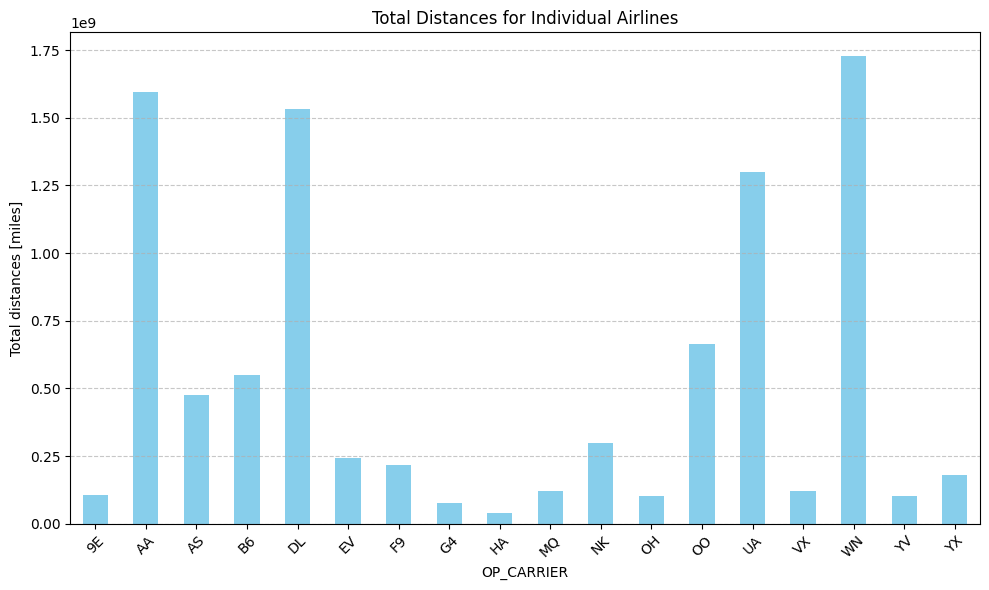

TypeError: Cannot setitem on a Categorical with a new category (False), set the categories first

In [7]:
run_plots(dataset)

In [7]:
dataset.head(n=100)

,ID,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,FL_YEAR,FL_MONTH,FL_DAY,ARR_DELAY,DELAY,MOONPHASE,CONDITIONS,CLOUDCOVER,VISIBILITY,PRESSURE,WINDDIR,WINDSPEED,WINDGUST,SNOWDEPTH,SNOW,PRECIPPROB,PRECIP,DEW,HUMIDITY,TEMP,FEELSLIKE,ice,freezingrain,snow,rain,id,datatype,day_of_week,month
0,907.00000,EV,CAE,248,655,815,806,140,666,2017,1,1,-9,0,0.12000,"Rain, Partially cloudy",81.90000,7.60000,1021.30000,27.00000,1.20000,NaN,0.00000,0.00000,100.00000,0.00100,42.20000,90.30000,44.90000,44.90000,0,0,0,1,NaN,2017-01-01,7,2
1,5833.00000,EV,CAE,21,615,725,726,70,192,2017,1,1,1,1,0.12000,"Rain, Partially cloudy",81.90000,7.60000,1021.30000,27.00000,1.20000,NaN,0.00000,0.00000,100.00000,0.00100,42.20000,90.30000,44.90000,44.90000,0,0,0,1,NaN,2017-01-01,7,2
2,7651.00000,DL,CAE,21,1530,1644,1643,74,192,2017,1,1,-1,0,0.12000,Overcast,100.00000,3.50000,1021.50000,85.00000,4.50000,NaN,0.00000,0.00000,0.00000,0.00000,50.80000,91.03000,53.30000,53.30000,0,0,0,0,NaN,2017-01-01,7,2
3,8698.00000,DL,CAE,21,828,938,1111,70,192,2017,1,1,173,1,0.12000,"Rain, Partially cloudy",64.30000,3.80000,1021.80000,0.00000,0.00000,NaN,0.00000,0.00000,100.00000,0.01400,43.80000,91.62000,46.10000,46.10000,0,0,0,1,NaN,2017-01-01,7,2
4,9237.00000,EV,CAE,248,1634,1757,1736,143,666,2017,1,1,-21,0,0.12000,"Rain, Overcast",100.00000,1.80000,1021.60000,70.00000,5.10000,NaN,0.00000,0.00000,100.00000,0.01000,51.50000,91.61000,53.90000,53.90000,0,0,0,1,NaN,2017-01-01,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,138280.00000,EV,CAE,164,1725,1919,1924,174,878,2017,1,10,5,1,0.44000,Clear,17.30000,9.90000,1028.90000,307.00000,2.40000,NaN,0.00000,0.00000,0.00000,0.00000,36.50000,44.84000,57.80000,57.80000,0,0,0,0,NaN,2017-01-10,2,2
96,138377.00000,EV,CAE,248,1716,1835,1842,139,666,2017,1,10,7,1,0.44000,Clear,17.30000,9.90000,1028.90000,307.00000,2.40000,NaN,0.00000,0.00000,0.00000,0.00000,36.50000,44.84000,57.80000,57.80000,0,0,0,0,NaN,2017-01-10,2,2
97,142458.00000,EV,CAE,21,700,820,756,80,192,2017,1,11,-64,0,0.47000,Overcast,100.00000,9.90000,1028.10000,332.00000,1.20000,NaN,0.00000,0.00000,0.00000,0.00000,46.70000,89.31000,49.70000,49.70000,0,0,0,0,NaN,2017-01-11,3,2
98,142490.00000,EV,CAE,21,2010,2123,2058,73,192,2017,1,11,-65,0,0.47000,Clear,15.10000,9.90000,1026.70000,292.00000,1.40000,NaN,0.00000,0.00000,0.00000,0.00000,49.30000,68.34000,59.70000,59.70000,0,0,0,0,NaN,2017-01-11,3,2


In [8]:
dataset.columns.values

array(['ID', 'OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME',
       'CRS_ARR_TIME', 'ARR_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE',
       'FL_YEAR', 'FL_MONTH', 'FL_DAY', 'ARR_DELAY', 'DELAY', 'MOONPHASE',
       'CONDITIONS', 'CLOUDCOVER', 'VISIBILITY', 'PRESSURE', 'WINDDIR',
       'WINDSPEED', 'WINDGUST', 'SNOWDEPTH', 'SNOW', 'PRECIPPROB',
       'PRECIP', 'DEW', 'HUMIDITY', 'TEMP', 'FEELSLIKE', 'ice',
       'freezingrain', 'snow', 'rain', 'id', 'datatype', 'day_of_week',
       'month'], dtype=object)

# A small peek on size of data




It's definetely too much, we need to make it smaller, especially the string columns. We would like to convert big string data into mappings of ints to strings. Lets look at example of big columns:

In [ ]:
## do wyjebania imo  AIRLINE_DOT,AIRLINE_DOT,DOT_CODE,ORIGIN,DEST ewentualnie zostawic skroty i zrobic jakis slownik do wypisywania
for col_name in dataset.columns.values:
  print(f"Size in mb of {col_name} : {sys.getsizeof(dataset[col_name]) / 10 ** 6} mb, Type {dataset[col_name].dtype}")
print(f"Data size : {sys.getsizeof(dataset) / 10 ** 9} in GB")

# Data Discovery

Info about columns:

In [4]:
print(f"There ara {dataset.shape[0]} rows and {dataset.shape[1]} columns.")

There ara 12651227 rows and 38 columns.


In [5]:
dataset.columns.values

array(['ID', 'OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME',
       'CRS_ARR_TIME', 'ARR_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE',
       'FL_YEAR', 'FL_MONTH', 'FL_DAY', 'ARR_DELAY', 'DELAY', 'MOONPHASE',
       'CONDITIONS', 'CLOUDCOVER', 'VISIBILITY', 'PRESSURE', 'WINDDIR',
       'WINDSPEED', 'WINDGUST', 'SNOWDEPTH', 'SNOW', 'PRECIPPROB',
       'PRECIP', 'DEW', 'HUMIDITY', 'TEMP', 'FEELSLIKE', 'ice',
       'freezingrain', 'snow', 'rain', 'id', 'datatype', 'day_of_week',
       'month'], dtype=object)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12651227 entries, 0 to 12651226
Data columns (total 38 columns):
 #   Column            Dtype         
---  ------            -----         
 0   ID                float64       
 1   OP_CARRIER        category      
 2   ORIGIN            category      
 3   DEST              int64         
 4   CRS_DEP_TIME      int64         
 5   CRS_ARR_TIME      int64         
 6   ARR_TIME          int64         
 7   CRS_ELAPSED_TIME  int64         
 8   DISTANCE          int64         
 9   FL_YEAR           uint32        
 10  FL_MONTH          uint16        
 11  FL_DAY            uint16        
 12  ARR_DELAY         int64         
 13  DELAY             uint16        
 14  MOONPHASE         float64       
 15  CONDITIONS        object        
 16  CLOUDCOVER        float64       
 17  VISIBILITY        float64       
 18  PRESSURE          float64       
 19  WINDDIR           float64       
 20  WINDSPEED         float64       
 21  WINDGU

Mean of delays:

In [ ]:
delays = dataset['DELAY']
delays.mean()

Check how many nans in dataframe:

Maybe we should remove windgust? So many NaNs, probably no colleration, ID?

In [ ]:

def check_nans():
  # since all len's are same
  n = len(dataset['DELAY'])
  for col in dataset.columns.values:
    nans = dataset[col].isna().sum()
    print(f"Col name: {col} nans: {nans}   {(nans / n) * 100} %")
  print(f"There are {n} rows")

check_nans()


# Time for some plots:

Pie graph of delays:

In [ ]:
def wykreskolowydelay(df):
    delayed_flights = df[df['DELAY'] > 0]
    percentages = [len(delayed_flights) / len(df) * 100, 100 - len(delayed_flights) / len(df) * 100]
    labels = ['Delayed', 'Non-delayed']
    plt.figure(figsize=(8, 8))
    plt.pie(percentages, labels=labels, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'], startangle=90)
    plt.title('Percentage of delayed')
    plt.show()

def wykresmiesiacdealay(df):
    monthly_delays = df.groupby(df['FL_MONTH'])['DELAY'].mean() * 100
    plt.figure(figsize=(10, 6))
    monthly_delays.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Procentowe opóźnienia')
    plt.xlabel('Miesiąc')
    plt.ylabel('Procentowe opóźnienie')
    plt.xticks(rotation=0)
    plt.show()

def wykresmiesiacliczbalotow(df):
    monthly_delays = df.groupby(df['FL_MONTH'])['id'].count()
    print(monthly_delays)
    plt.figure(figsize=(10, 6))
    monthly_delays.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Liczba lotów na miesiąc')
    plt.xlabel('Miesiąc')
    plt.ylabel('Liczba lotów')
    plt.xticks(rotation=0)
    plt.show()
def wykresmiesiacopoznienie(df):
    monthly_delays = df.groupby('FL_MONTH')['DELAY'].sum()
    plt.figure(figsize=(10, 6))
    print(monthly_delays)
    monthly_delays.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Ilość opóźnionych lotów')
    plt.xlabel('Miesiąc')
    plt.ylabel('Liczba opóźnień')
    plt.xticks(rotation=0)
    plt.show()

graphs = [wykreskolowydelay, wykresmiesiacdealay, wykresmiesiacliczbalotow, wykresmiesiacopoznienie]

for g in graphs:
    g(dataset)

# Data Preprocessing

## Data Cleaning

Let's remove windgust, since it doesn't provide any important data (does it?) and contains of lots of nans.
Also, 8 percents of snow might be too much. For now, we will remove it and maybe later on we will return it back.

In [ ]:
dataset = dataset.drop(['WINDGUST', 'SNOW', "SNOWDEPTH", "ID", "id"], axis = 1, errors = 'ignore')
dataset.head(100)

In [ ]:
check_nans()

Now it would be great if we removed NaN rows, I will remove all NaN rows from MOONPHASE, CONDITIONS etc. I know only by seeing those rows, that there since moonphase and conditions and cloudcover etc. have 0.002481972697193719 % of nans, they have nans on all rows. So i need to remove only moonphase visibility and pressure rows with NaN's.

In [ ]:
nan_cols = ["MOONPHASE", 'VISIBILITY', 'PRESSURE']

dataset.dropna(subset = nan_cols, inplace = True)

Now lets look at nans in overall:

In [ ]:
check_nans()

We have our data cleaned. Data we imported had ~12.65 mln. rows, after cleaning we have ~12.64 mln. rows. (???)

## Custom Transformers

## Feature Scaling

## Tranformation Pipelines

# Exploratory Data Analysis

# Machine Learning Proccess

In [ ]:
def LogREG(X_train,X_test,y_train,y_test):
    model = LogisticRegression(max_iter=1000)

    # Different logistic regression parameters to try
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag']}

    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best model from the grid search
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Print results
    print("LR best parameters:", best_params)
    print("Accuracy:", accuracy)

def SVM(X_train, X_test, y_train, y_test):
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)

    print(f'Dokładność klasyfikacji: {accuracy:.2f}')

    # Wyświetlanie pełnego raportu klasyfikacji
    print('\nRaport klasyfikacji:')
    print(classification_report(y_test, y_pred))

In [ ]:
'''X = dataset.loc[:, dataset.columns != "DELAY"]
y = dataset["DELAY"]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.1)
'''




In [ ]:
#LogREG(X_train, X_test, y_train, y_test)
#SVM(X_train, X_test, y_train, y_test)